# Exploration of the Heart Disease Data Set

## Introduction

The dataset is taken from the Cleveland, Ohio database. This dataset is a collaboration with physicians from Hungary, Switzerland, Virginia, and Ohio. This database describes 76 attributes, but all experiments that have been published use only 14 as a reference. The `num` column describes the presence of heart disease in the patient. The `col_vessels` column indicates the number of major blood vessels coloured by fluoroscopy. The `slope` column indicates the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope). The `st_depression` column indicates the ST depression induced by exercise relative to rest. The `ex_ang` column indicates whether the patient has exercise induced angina (1 = yes, 0 = no). The `max_hr` column describes indicates a numerical value of the maximum heart rate achieved. The `rest_ecg` indicates the resting electrocardiac results (0 = normal, 1 = ST-T wave abnormality, 2 = probable/definite left ventricular hypertrophy). The `fbs` column indicates whether the patient has a fasting blood sugar of greater than 120 mg/dl (1 = true, 0 = false). The `chol` column describes the serum cholesterol level in mg/dl per patient. The `rest_bps` indicates the resting blood pressure (mm Hg). The `chest_pain` column describes the chest pain in the patient with varying types of anginas (1 = typical angina, 2 = atypical angina, 3 = nonanginal pain, 4 = asymptomatic). The `sex` column indicates the gender of the patient (1 = male, 0 = female). The `defect` column refers to the defect of the heart (3 = normal, 6 = defect, 7 = reversible defect). Lastly, the `age` column indicates the age of the patient. 

The question we will try to answer is whether a patient will be diagnosed with heart disease, and it's severity. We have a number of predictors, and we will use the technique of backward selection to narrow down our predictors to the few attributes that allow us to predict this most accurately.



## Methods & Results

In [23]:
library(tidyverse)
library(tidymodels)
library(repr)
library(MASS)
library(GGally)
library(caret)
options(repr.matrix.max.rows = 6)

### Read the dataset, clean and wrangle the data into a tidy format.

Download the dataset from the url and store it into a local file.

In [24]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

download.file(url, destfile = "data/processed.cleveland.data")

Read the file into the dataframe `heart_disease_original`. We will need to manually specify the column types, which are given on the database website.

In [25]:
heart_disease_original <- read_csv("data/processed.cleveland.data",
                                   # add column names
                                   col_names = c("age",
                                                 "sex",
                                                 "chest_pain", 
                                                 "rest_bps", 
                                                 "chol", 
                                                 "fbs", 
                                                 "rest_ecg", 
                                                 "max_hr", 
                                                 "ex_ang", 
                                                 "st_depression", 
                                                 "slope", 
                                                 "col_vessels", 
                                                 "defect", 
                                                 "num"))

head(heart_disease_original, 10)

Rows: 303 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): col_vessels, defect
dbl (12): age, sex, chest_pain, rest_bps, chol, fbs, rest_ecg, max_hr, ex_an...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,rest_bps,chol,fbs,rest_ecg,max_hr,ex_ang,st_depression,slope,col_vessels,defect,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2
53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1


Now, we need to wrangle `heart_disease_original` by removing all rows that contain a question mark, filtering essentially NA values and changing the type of `col_vessels` and `defect` to be doubles.

In [26]:
heart_disease <- heart_disease_original %>% 

                    # remove all rows that contain a question
                    # mark (esentially NA values) to supress
                    # warnings from R
                    filter(defect != "?", col_vessels != "?") %>%

                    # change columns col_vessels and defect to be numeric
                    # to allow for tidymodels to work properly
                    mutate(col_vessels = as.numeric(col_vessels),
                           defect = as.numeric(defect),
                           num = as_factor(num)) %>%

                    # remove rows with NA values
                    na.omit()     


head(heart_disease, 10)

age,sex,chest_pain,rest_bps,chol,fbs,rest_ecg,max_hr,ex_ang,st_depression,slope,col_vessels,defect,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
63,1,4,130,254,0,2,147,0,1.4,2,1,7,2
53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


Let's check the distribution for our target variable `num`. 

In [27]:
heart_disease %>% 
   group_by(num) %>% 
   summarize(count = n()) %>%
   # we can find the percent by dividing count for each
   # num by nrow(heart_disease) which gives us the amount
   # of rows in heart_disease
   mutate(percent = 100 * (count/nrow(heart_disease)))

num,count,percent
<fct>,<int>,<dbl>
0,160,53.872054
1,54,18.181818
2,35,11.784512
3,35,11.784512
4,13,4.377104


It looks like there is an uneven proportion of data for `num`. There is a proportionally high amount of rows where `num` is 0 vs where `num` is 1, 2, 3, or 4. Due to the lack of distribution of data, we will likely not get a very accurate k-nn model. We will solve this problem later by upsampling our training data. For now, let's continue as normal. 

### Split the dataset into training set and testing set.

We will split our dataset `heart_diease` into a testing and training set. We will upsample the training set, which will hopefully increase the accuracy of our model.

In [28]:
# setting a seed which will not be changed for the rest of the project
set.seed(2023)

heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = num)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

head(heart_disease_training)

age,sex,chest_pain,rest_bps,chol,fbs,rest_ecg,max_hr,ex_ang,st_depression,slope,col_vessels,defect,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
57,1,4,140,192,0,0,148,0,0.4,2,0,6,0
56,0,2,140,294,0,2,153,0,1.3,2,0,3,0


Now, we will use the `upSample` function from `caret` to upsample all the minority classes in `heart_disease_training` to have the same amount of observations as the majority class. 

In [29]:
heart_disease_training_upsampled <- upSample(x = heart_disease_training[,-ncol(heart_disease_training)],
                                             y = heart_disease_training$num) %>%
                                    # upSample changes the name of the column of the factor variable to
                                    # Class so we will change it back to num manually
                                    mutate(num = Class) %>%
                                    dplyr::select(-Class)

head(heart_disease_training_upsampled, 160)

,age,sex,chest_pain,rest_bps,chol,fbs,rest_ecg,max_hr,ex_ang,st_depression,slope,col_vessels,defect,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
2,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
3,56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
158,63,0,4,124,197,0,0,136,1,0.0,2,0,3,1
159,57,0,4,140,241,0,0,123,1,0.2,2,0,7,1
160,45,1,1,110,264,0,0,132,0,1.2,2,0,7,1


Now we will compare the distribution of `num` between our original training data and our upsampled training data.

In [30]:
heart_disease_training %>% 
   group_by(num) %>% 
   summarize(count = n()) %>%
   mutate(percent = 100 * (count/nrow(heart_disease_training)))

heart_disease_training_upsampled %>% 
   group_by(num) %>% 
   summarize(count = n()) %>%
   mutate(percent = 100 * (count/nrow(heart_disease_training_upsampled)))

num,count,percent
<fct>,<int>,<dbl>
0,120,54.298643
1,40,18.099548
2,26,11.764706
3,26,11.764706
4,9,4.072398


num,count,percent
<fct>,<int>,<dbl>
0,120,20
1,120,20
2,120,20
3,120,20
4,120,20


As we can see, in `heart_disease_training`, the distribution of `num` is quite uneven which is what we expected given the distribution of `num` in the original data set. However, in `heart_disease_training_upsampled`, the distribution of `num` is exactly 20% for each factor. This indicates to us that upsampling worked properly. 

### Selecting Predictors

#### GGPairs

To choose our predictor variables, we will use `ggpairs` to find the correlation between all the variables and our factor variable `num`. We will then decide which variable seems to be significant between determining between different factors of `num`. 

However, since we have a lot of predictor variables, to make it easy to view 14 different graphs, we will break our dataset into 2 smaller datasets and view them separately to make it more legible.


In [31]:
heart_disease_training_1 <- heart_disease_training_upsampled %>%
    # select the first 7 columns as well as num 
    dplyr::select(1:7, num)

heart_disease_training_2 <- heart_disease_training_upsampled %>%
    # select the remaining columns
    dplyr::select(8:14)

head(heart_disease_training_1)
head(heart_disease_training_2)

,age,sex,chest_pain,rest_bps,chol,fbs,rest_ecg,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,37,1,3,130,250,0,0,0
2,41,0,2,130,204,0,2,0
3,56,1,2,120,236,0,0,0
4,57,0,4,120,354,0,0,0
5,57,1,4,140,192,0,0,0
6,56,0,2,140,294,0,2,0


,max_hr,ex_ang,st_depression,slope,col_vessels,defect,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,187,0,3.5,3,0,3,0
2,172,0,1.4,1,0,3,0
3,178,0,0.8,1,0,3,0
4,163,1,0.6,1,0,3,0
5,148,0,0.4,2,0,6,0
6,153,0,1.3,2,0,3,0


In [32]:
big_plot_1 <- ggpairs(heart_disease_training_1, 
                      # make the text size bigger 
                      upper = list(continuous = wrap("cor", size = 10)),
                      # color the output by our factor variable and make
                      # the graphs translucent
                      ggplot2::aes(colour = num, alpha = 0.2))

big_plot_2 <- ggpairs(heart_disease_training_2, 
                      upper = list(continuous = wrap("cor", size = 10)),
                      ggplot2::aes(colour = num, alpha = 0.2))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


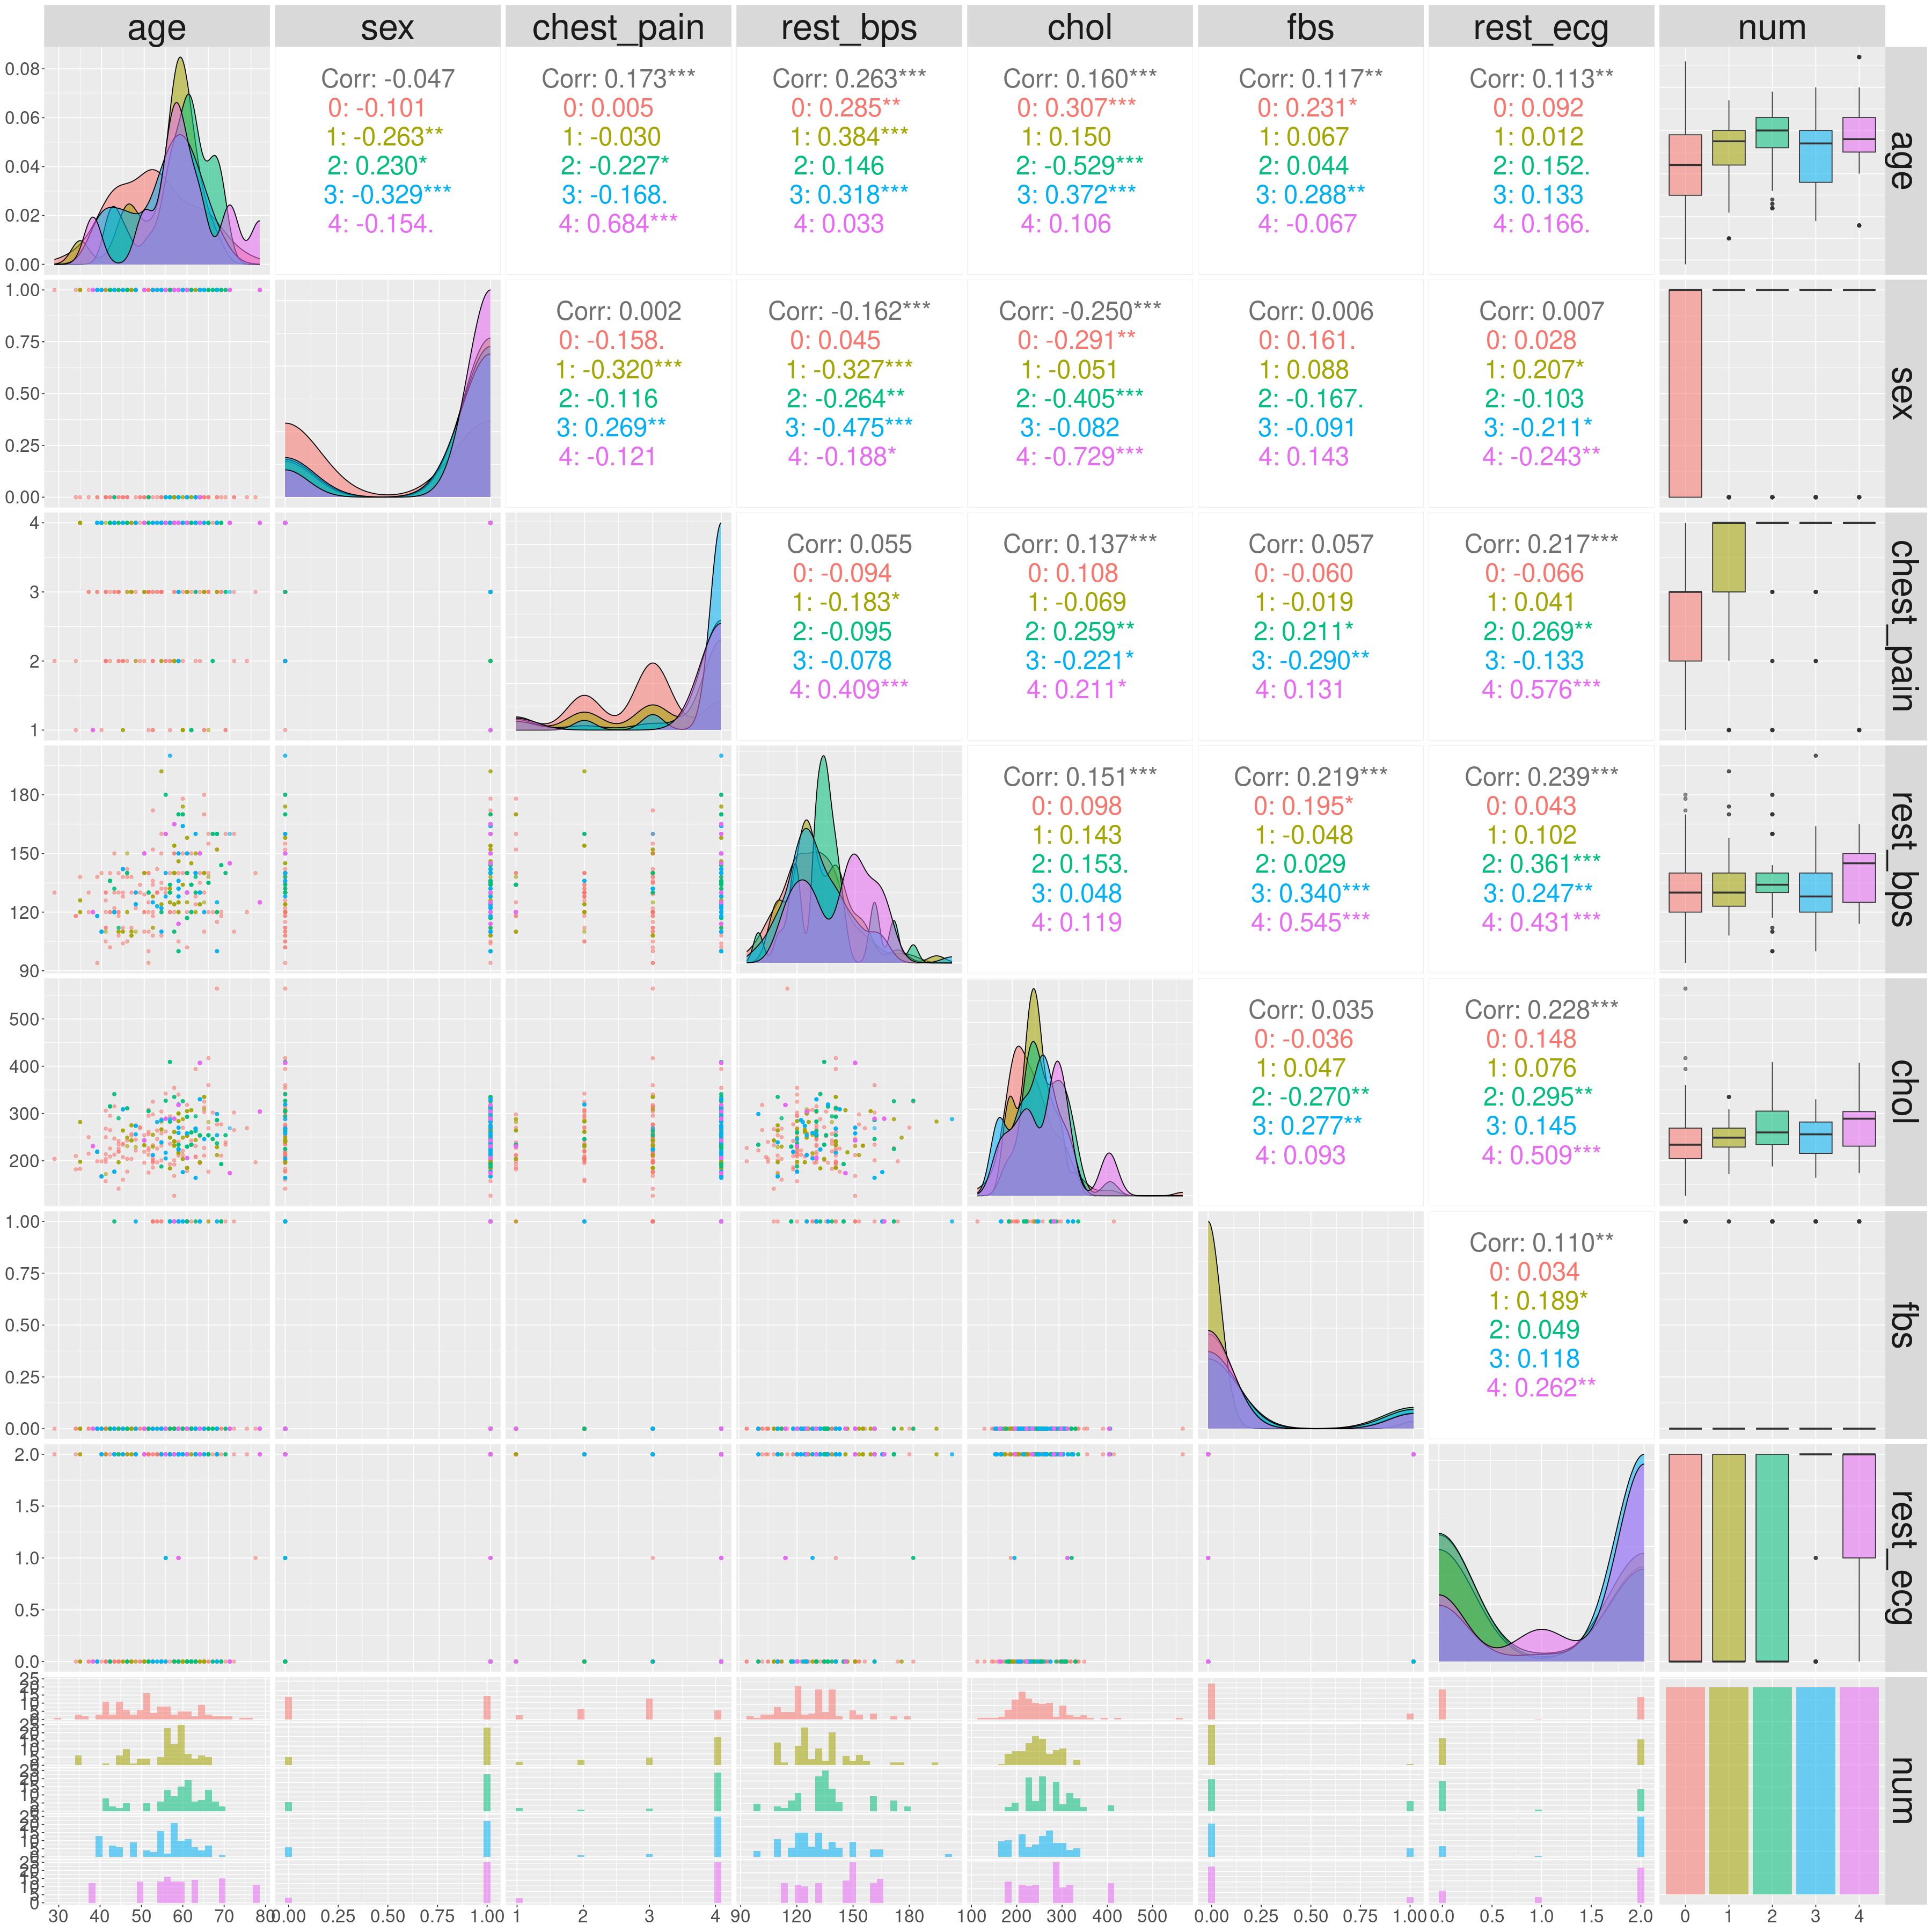

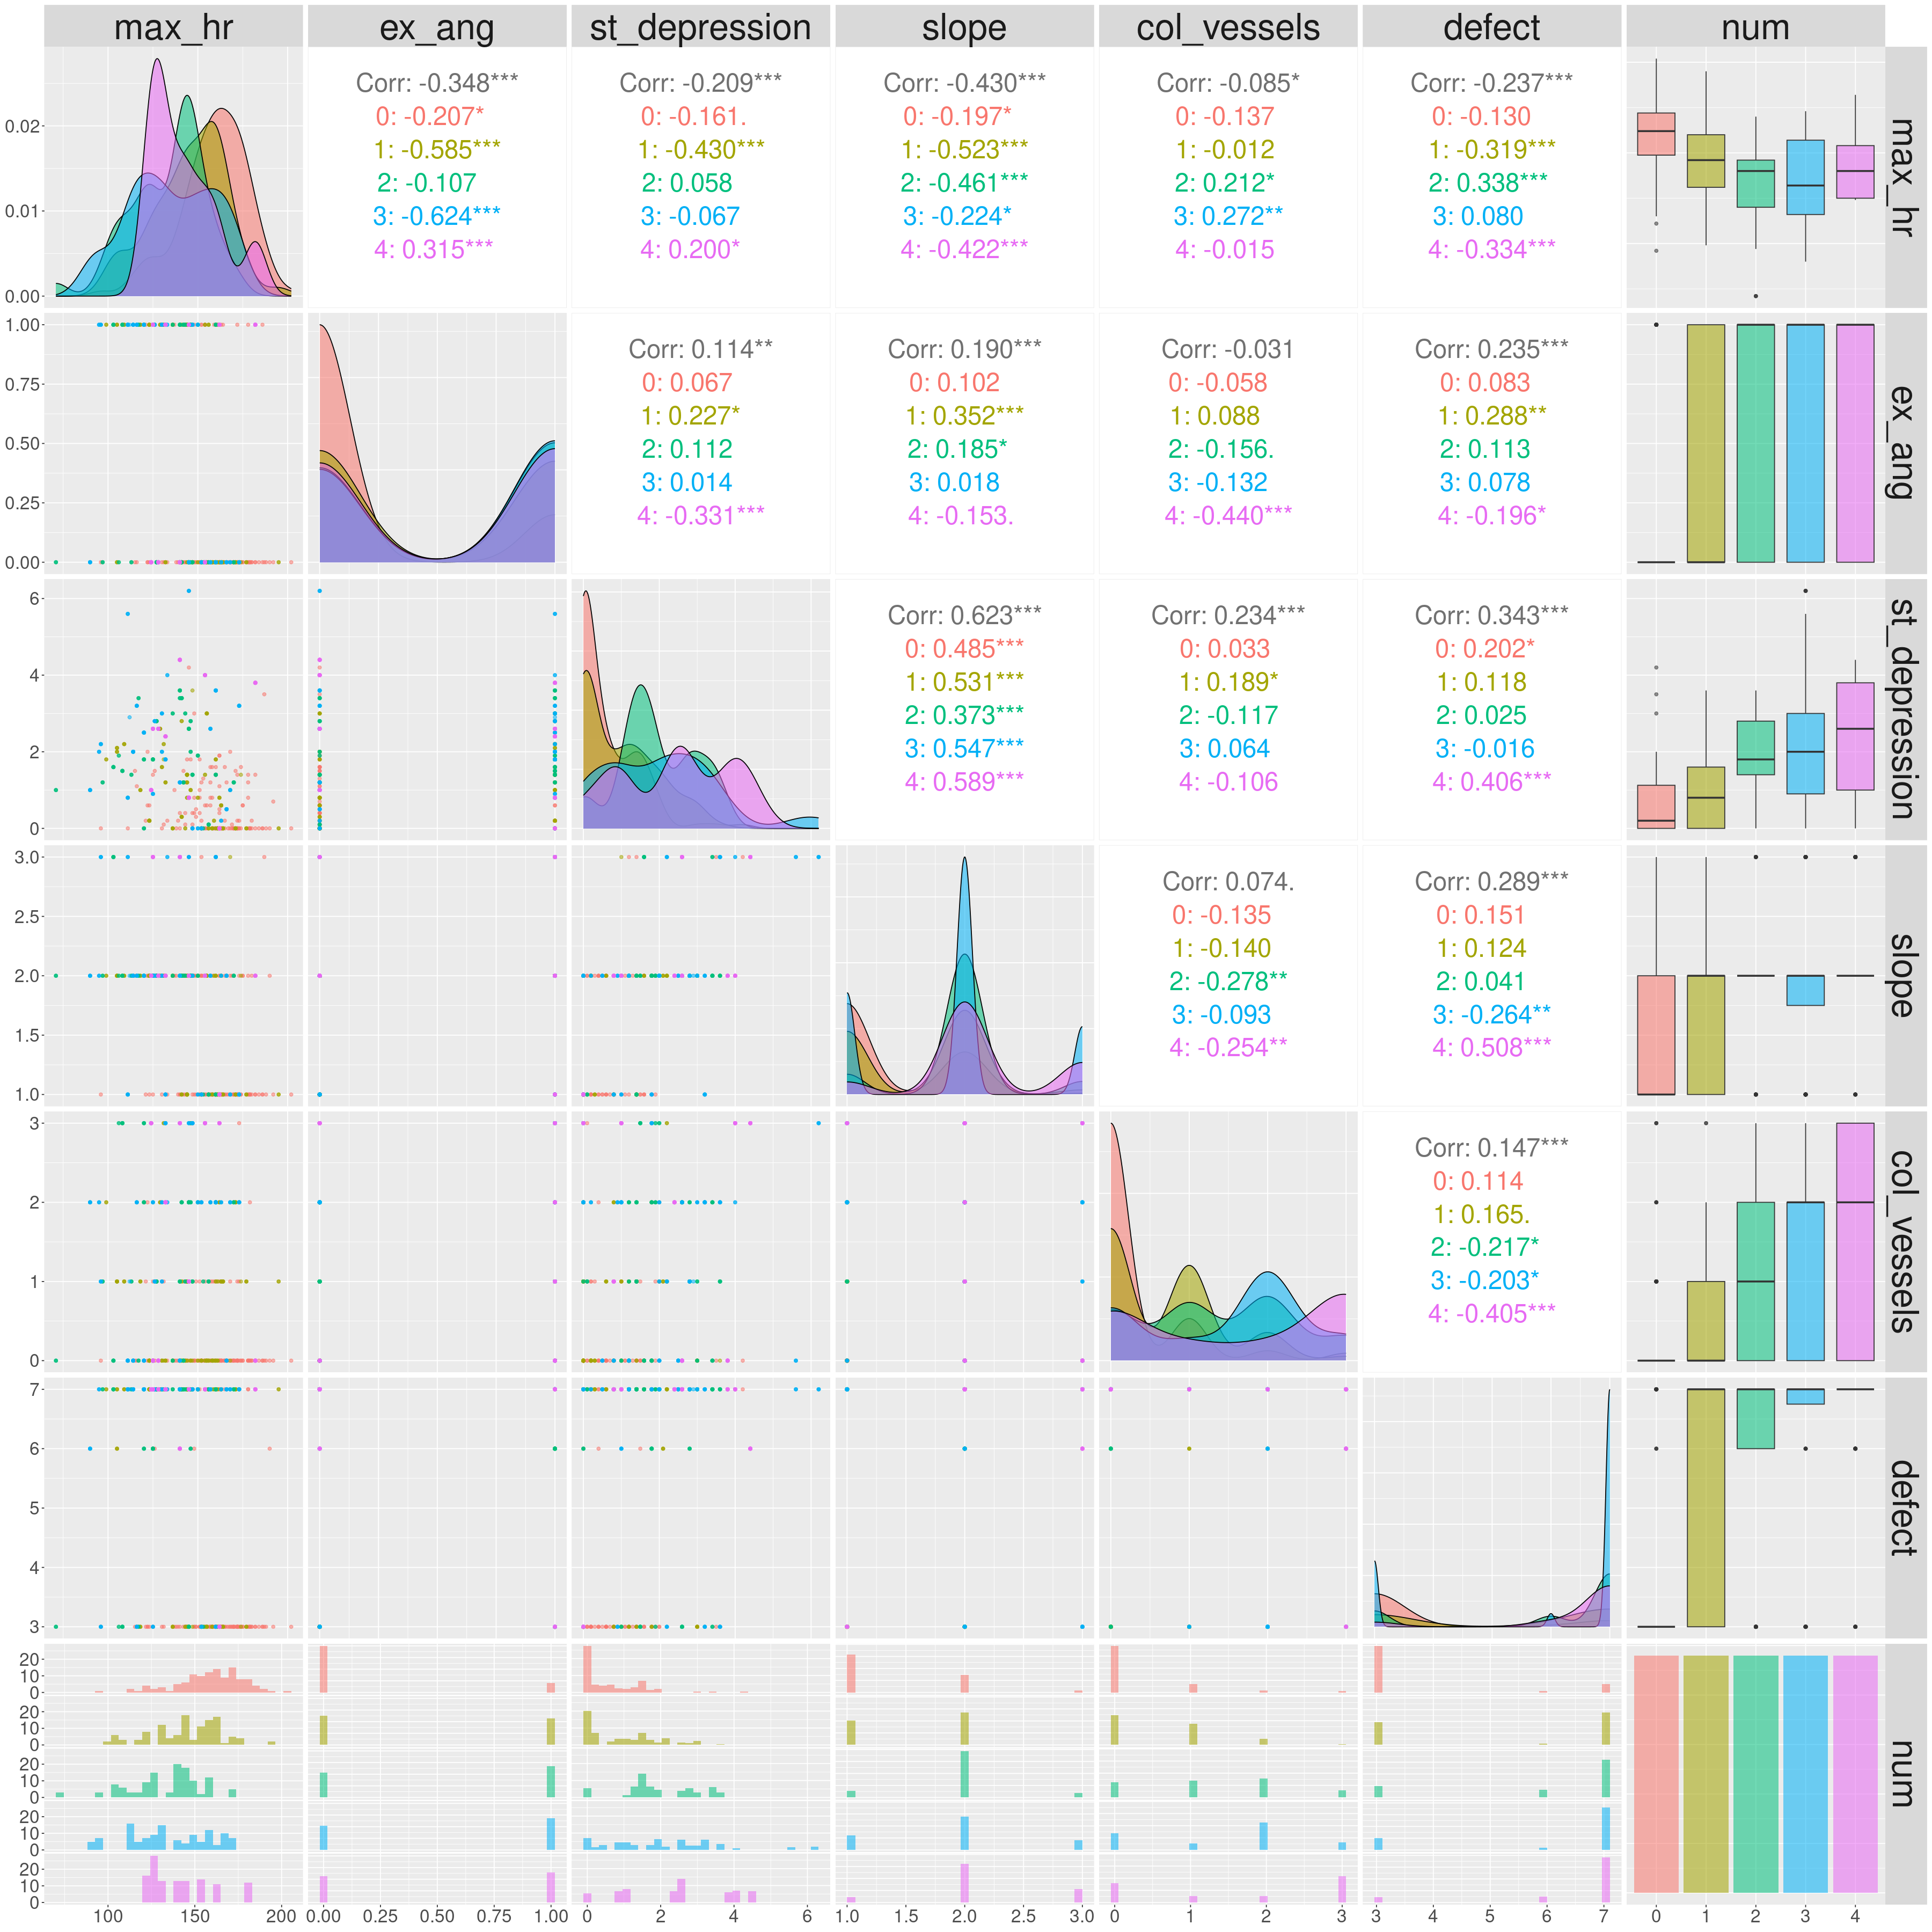

In [33]:
options(repr.plot.width = 30, repr.plot.height = 30)
 
big_plot_1 + # make all text bigger
             theme(text = element_text(size = 50), 
                   # adjust the axis text to be a bit smaller 
                   axis.text = element_text(size = 20))

big_plot_2 + theme(text = element_text(size = 50), 
                   axis.text = element_text(size = 20))

We will mainly be looking at the diagonal curves of these graphs. 

For the first graph, it looks like `age` and `chol` show a significant difference between different types of `num`. Surprisingly, it doesn't seem like `chest_pain` is a good predictor between the different types of `num`. We can see a big blue spike (correlating to `num = 3`) at high values of `chest_pain` but otherwise, all the curves look quite similar. Furthermore, it's tough to determine whether `rest_ecg` is a good predictor since even though there seems to be separation between the curves, the curves all follow the same trend; they rise and fall at the same locations. All the other predictors seem to be bad at differentiating between the different curves.

For the second graph, it looks like `max_hr`, `slope`, `col_vessels` and `defect` are good predictors, whereas it's tough to determine whether `st_depression` is good or not. It also tends to rise and fall at the same location. 

To qualitatively determine which predictors to use, we will use the method of backward selection.

#### Backward Selection

Section 6.8.3 of the data science textbook briefly mentions the method of forward selection in R. However, the method it shows is far too manual. The more manual we make our program, the more prone it is to errors. Therefore, we will be using the `MASS` library to import a few functions which allow us to do the same thing.

 Therefore, instead of forward selection, we will use backward selection to remove one predictor at a time. Then, we will check if the AIC of the new model goes down. We will remove the predictor which lowers the AIC the most until we get to a point where removing predictors increases AIC. 
 
AIC is a measure used to evaluate the goodness of fit of a statistical model. It takes into account both the complexity of the model and its performance in explaining the data. The main goal of AIC is to find the best balance between model complexity and its ability to explain the observed data. Lower AIC values indicate better model performance, while higher AIC values indicate worse model performance.

During the backward selection process, we remove the predictor that, when removed, results in the lowest AIC value for the reduced model. We continue to remove predictors one by one, stopping when any further removal of predictors would result in an increase in AIC. By removing predictors that reduce the AIC of the model, we can identify the combination of predictors that provides the best balance between model complexity and predictive accuracy.

In [34]:
# the MASS library requires all values to be an integer
heart_disease_training_aic <- heart_disease_training %>%
    mutate(num = as.numeric(num))

In [35]:
null <- lm(num ~ 1, data = heart_disease_training_aic) # 1 means no predictor 
full <- lm(num ~ ., data = heart_disease_training_aic) # use all predictors
 
# this function goes from full (all predictors) to null (no predictors) 
# and removes the predictor whose removal decreases the AIC the most
stepAIC(full, scope = list(lower = null, upper=full), 
         data = heart_disease_training_aic,
         direction = 'backward')

Start:  AIC=-77.74
num ~ age + sex + chest_pain + rest_bps + chol + fbs + rest_ecg + 
    max_hr + ex_ang + st_depression + slope + col_vessels + defect

                Df Sum of Sq    RSS     AIC
- fbs            1    0.0844 137.04 -79.606
- rest_ecg       1    0.6807 137.64 -78.647
- rest_bps       1    0.6913 137.65 -78.630
- ex_ang         1    0.7350 137.69 -78.560
- chol           1    0.9320 137.89 -78.244
<none>                       136.96 -77.742
- age            1    1.5141 138.47 -77.313
- slope          1    1.6196 138.58 -77.145
- max_hr         1    1.7337 138.69 -76.963
- sex            1    2.6434 139.60 -75.518
- st_depression  1    5.7668 142.73 -70.628
- chest_pain     1    7.9236 144.88 -67.313
- defect         1    8.8629 145.82 -65.885
- col_vessels    1   25.4863 162.45 -42.027

Step:  AIC=-79.61
num ~ age + sex + chest_pain + rest_bps + chol + rest_ecg + max_hr + 
    ex_ang + st_depression + slope + col_vessels + defect

                Df Sum of Sq    RSS   


Call:
lm(formula = num ~ age + sex + chest_pain + chol + max_hr + st_depression + 
    slope + col_vessels + defect, data = heart_disease_training_aic)

Coefficients:
  (Intercept)            age            sex     chest_pain           chol  
     0.427336      -0.009878       0.266004       0.243867       0.001666  
       max_hr  st_depression          slope    col_vessels         defect  
    -0.005350       0.197469       0.229587       0.424593       0.134384  


Looking at the output of `stepAIC`, it looks like it suggests that `sex` and `st_depression` were indeed good predictors for our model. Moreover, it also suggests the inclusion of `chest_pain` and `ex_ang` as a predictor. Looking at the graph, it does seem fair to not include `ex_ang` however it looks like `chest_pain` is a toss up. We will veer on the side of caution and not include it because given the amount of variables in the database, the fewer we have, the better our model will be.

Personally, we still believe that `sex` is not a good predictor due to the visual confirmation given by the `ggpairs` function, so we will use all the predictors that were given to use by the `stepAIC` function except for `sex`.

### Creation of k-nn Model

Since we don't know the best value of $k$ to use for the model, we will use `vfold` and the `tune()` function to determine the accuracy of the model at different values of $k$. Firstly, we will create the recipe.

In [36]:
# create recipe for k-nn using the previously mentioned predictors
heart_disease_recipe <- recipe(num ~ age + chest_pain + chol + max_hr + st_depression + slope + col_vessels + defect,
                               data = heart_disease_training_upsampled) %>%
                        # normalize data
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

We will start the $k$ value at 1 and set the upper limit to 70. We chose the upper limit of 70 since it is close enough to 120 (the majority classifier) that our model will naturally start losing accuracy. In an ideal world, we would have the upper limit at exactly the majority classifier but doing `vfold` with 100+ neighbours takes a long computation time.

In [37]:
# we will use a step value of 5 to provide high accuracy while not severly effecting
# computation speed
k_vals <- tibble(neighbors = seq(from = 1, to = 70, by = 5))

# create a standard 5 fold model of the training data
heart_disease_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)

# create the specification of our k-nn model using tune() for the neighbours value
heart_disease_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                 set_engine("kknn") %>%
                 set_mode("classification")

heart_disease_tune_results <- workflow() %>%
  # add our recipe and model
  add_recipe(heart_disease_recipe) %>%
  add_model(heart_disease_tune) %>%
  # tune the grid to involve vfold and tuned neighbour 
  tune_grid(resamples = heart_disease_vfold, grid = k_vals) %>%
  collect_metrics() 

# sort accuracies by the accuracy of the neighbour count
(accuracies <- heart_disease_tune_results %>%
  filter(.metric == "accuracy") %>%
  arrange(desc(mean)))

# get the k value with the highest accuracy
(best_k_value <- accuracies %>%
    dplyr::select(neighbors) %>%
    slice(1) %>%
    pull())

→ A | warning: There were 14 warnings in `dplyr::summarise()`.
               The first warning was:
               ℹ In argument: `.estimate = metric_fn(...)`.
               ℹ In group 1: `neighbors = 1`.
               Caused by warning:
               ! No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.
               ℹ Run `dplyr::last_dplyr_warnings()` to see the 13 remaining warnings.

There were issues with some computations   A: x1
There were issues with some computations   A: x1




neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
41,accuracy,multiclass,0.6107160,5,0.007594705,Preprocessor1_Model09
51,accuracy,multiclass,0.6022412,5,0.017507688,Preprocessor1_Model11
46,accuracy,multiclass,0.5972725,5,0.011295716,Preprocessor1_Model10
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,multiclass,0.5744154,5,0.02490749,Preprocessor1_Model03
1,accuracy,multiclass,0.5743342,5,0.02301434,Preprocessor1_Model01
6,accuracy,multiclass,0.5658440,5,0.01926925,Preprocessor1_Model02


[1] 41

It looks like a neighbour count of around 41-46 gives us the highest accuracy. To further hone in on the exact neighbour count which gives us the maximal accuracy, we will repeat this process once more with a more precise range for our k values.

In [38]:
# since 46 seems to be in the same range as 41 for the accuracy, we will let this tibble
# extend more to the right of the best_k_value than to the left
k_vals_precise <- tibble(neighbors = seq(from = best_k_value - 5, to = best_k_value + 10, by = 1))


# the rest of this code is essentially copy pasted from the last time we ran this
# workflow, but with updated names; notice that we can reuse our old recipe and 
# specification
heart_disease_tune_results_precise <- workflow() %>%
  add_recipe(heart_disease_recipe) %>%
  add_model(heart_disease_tune) %>%
  tune_grid(resamples = heart_disease_vfold, grid = k_vals_precise) %>%
  collect_metrics() 

(accuracies_precise <- heart_disease_tune_results_precise %>%
  filter(.metric == "accuracy") %>%
  arrange(desc(mean)))

(best_k_value_precise <- accuracies_precise %>%
    dplyr::select(neighbors) %>%
    slice(1) %>%
    pull())

→ A | warning: There were 16 warnings in `dplyr::summarise()`.
               The first warning was:
               ℹ In argument: `.estimate = metric_fn(...)`.
               ℹ In group 1: `neighbors = 36`.
               Caused by warning:
               ! No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.
               ℹ Run `dplyr::last_dplyr_warnings()` to see the 15 remaining warnings.

There were issues with some computations   A: x1
There were issues with some computations   A: x1




neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
43,accuracy,multiclass,0.6151604,5,0.007322524,Preprocessor1_Model08
44,accuracy,multiclass,0.6151604,5,0.012344424,Preprocessor1_Model09
41,accuracy,multiclass,0.6107160,5,0.007594705,Preprocessor1_Model06
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,multiclass,0.5886870,5,0.011833896,Preprocessor1_Model13
36,accuracy,multiclass,0.5883836,5,0.009783561,Preprocessor1_Model01
37,accuracy,multiclass,0.5880803,5,0.012356832,Preprocessor1_Model02


[1] 43

We will now plot the accuracy vs the neighbour count to get a better idea of what this data looks like.

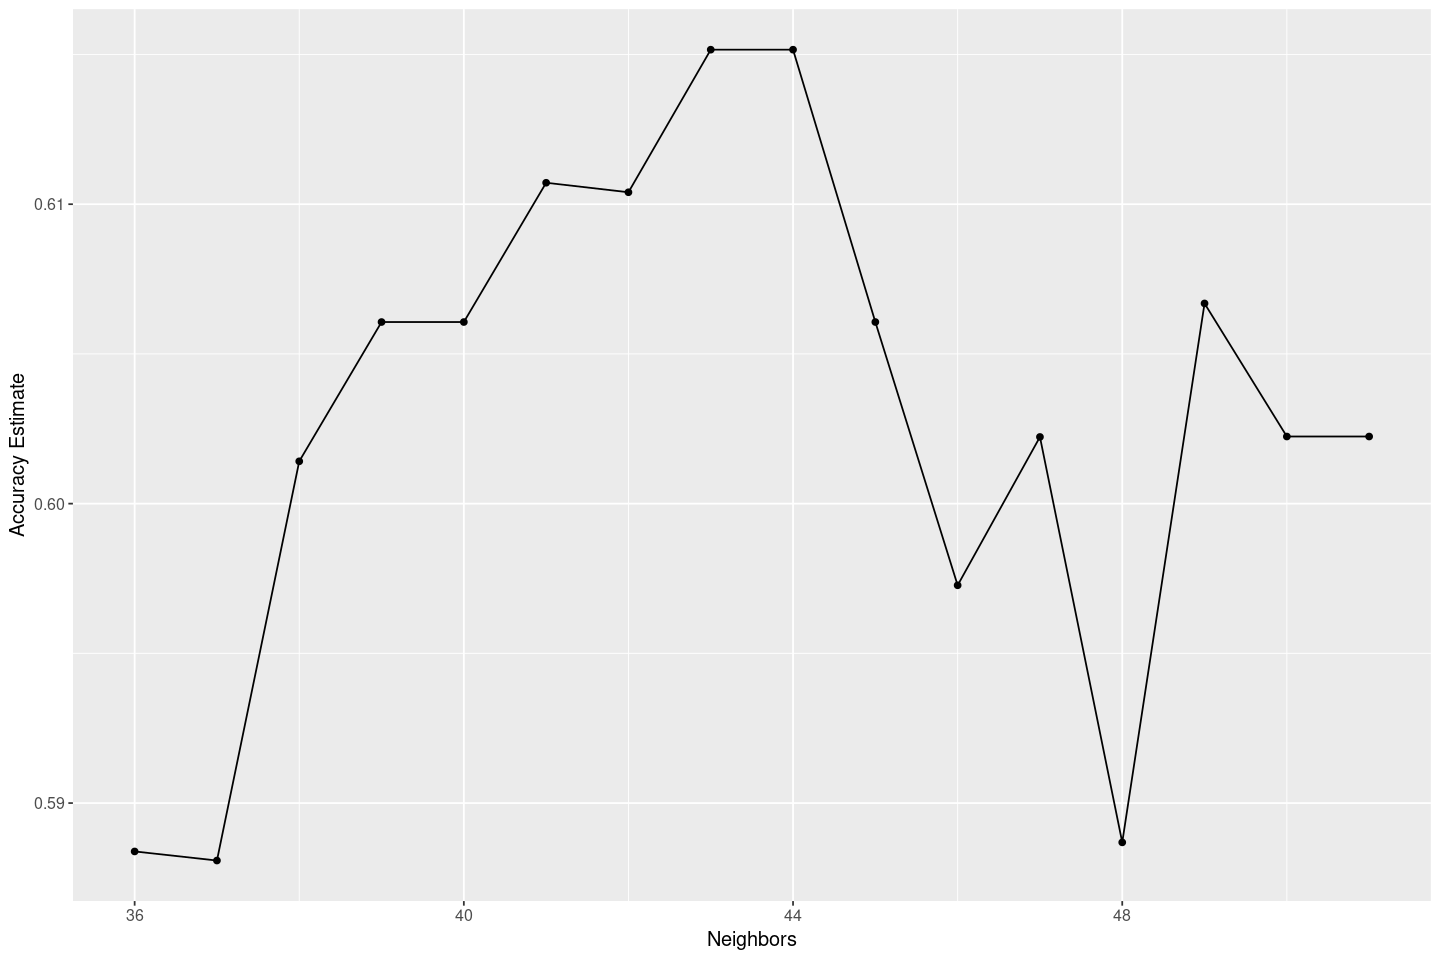

In [39]:
options(repr.plot.width = 12, repr.plot.height = 8)

(accuracy_vs_k_precise <- ggplot(accuracies_precise, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)))

It looks like $k = 38$ gives the highest accuracy value, which tapers and rises all the way to $k = 43$. From there it tapers off to a lower accuracy.

### Final Model with Known K-Value

In [40]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = best_k_value_precise) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(heart_disease_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = heart_disease_training)

In [41]:
heart_disease_test_predictions <- predict(knn_fit, heart_disease_testing) %>%
  bind_cols(heart_disease_testing)

(heart_disease_test_predictions %>%
  metrics(truth = num, estimate = .pred_class) %>%
  filter(.metric == "accuracy"))

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5921053


It looks like our final model accuracy is 59%. If we remember from before, our majority classifier was `num = 0` which made up of 54% of the original data. This means that our model's accuracy improved upon just guessing every patient to have no heart disease by 5%. This may not seem like much, but due to the un-uniformity of our data, it makes sense that we did not achieve an incredibly accurate model.

Let's visualize how our confusion matrix looks like.

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


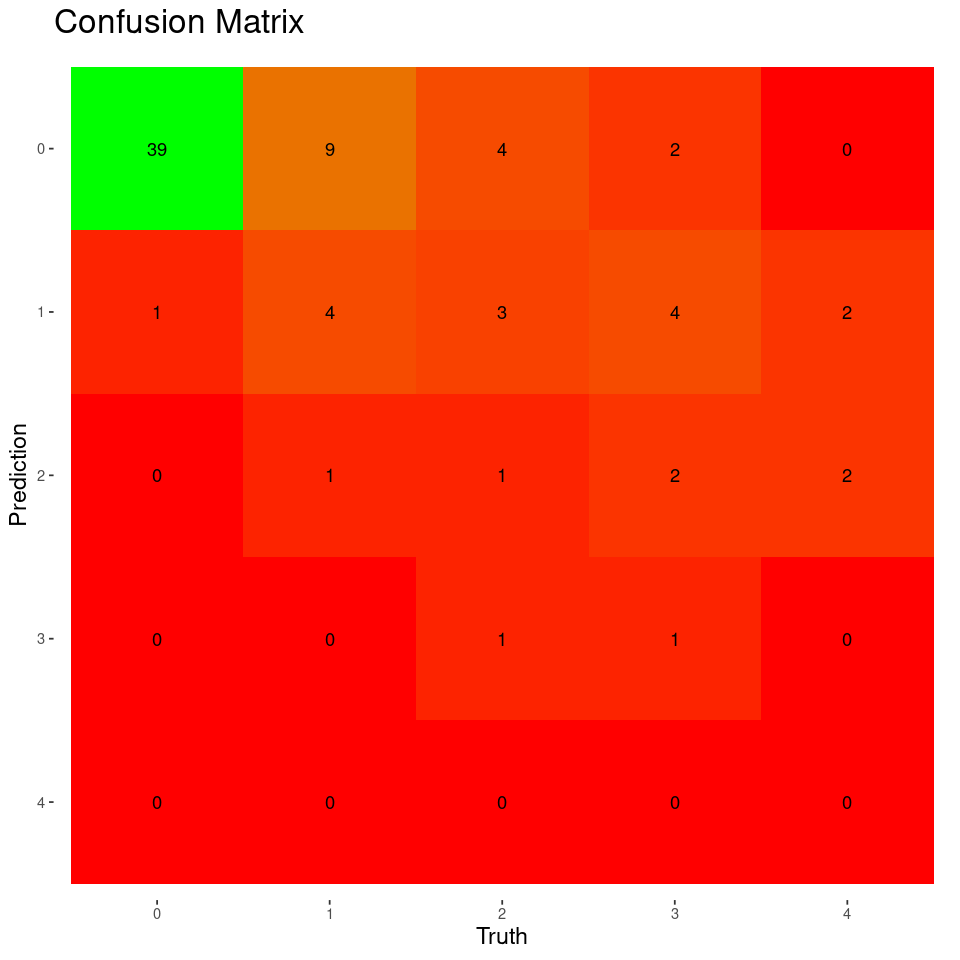

In [42]:
options(repr.plot.width = 8, repr.plot.height = 8)

confusion <- heart_disease_test_predictions %>%
             conf_mat(truth = num, estimate = .pred_class)

autoplot(confusion, type = "heatmap") +
  scale_fill_gradient(low = "red", high = "green") +
  ggtitle("Confusion Matrix") +
  # make all text bigger
  theme(
      axis.title.x = element_text(size = 14),
      axis.title.y = element_text(size = 14),
      plot.title = element_text(size = 20)
  )

It looks like our model is extremely accurate at guessing when the patient has no heart disease. There was only 1 case where the patient did not have heart disease but our model assumed they did. However, where our model struggles is classifying patients with heart disease. For a `num` value of 2 and 3, our model only correctly classified once whereas it was never accurate in correctly classifying a `num` value of 4. This makes sense, since we had an under-representation of the `num` values of 1, 2, 3, and 4 in our original data which we had to compensate for by upsampling.

## Discussion

Our model used the k-nearest neighbours algorithm with the data set of Cleveland heart disease patients to come up with an accuracy of 59% when determining the presence or lack thereof of heart disease (and the type of heart disease detected). Since the majority classifier in the data was 54%, our model improved on the majority classifier by 5%. If we look at the confusion matrix, our model is very good at determining cases where the patient had no heart disease. This was to be expected given the oversampling of cases in the data set where the patient had no heart disease.

These findings can be important to future studies or can be put to use at current medical institutions. However, we would need for this model to be a lot more accurate than 59% before we start seeing real life usage of it. We believe that firstly, more data needs to be collected. Somewhere in the level of `n = 1000-5000`. Then, we can possibly see a highly accurate models which could be used to quickly classify patients. If the model predicts any patients with `num = 3` or `num = 4`, we know then that there is a high possibility that this patient has severe heart disease and should be checked with promptly. 

Future questions and research directions could include:

1. How can we improve the accuracy of the model further? Are there other machine learning algorithms or techniques that might yield better results with this dataset, such as logistic regression, support vector machines, or deep learning?
2. What additional features or predictors could be included in the analysis to improve the model's performance? Are there any other medical tests or patient characteristics that might be relevant in predicting heart disease?
3. How does the model's performance change when trained on a larger, more diverse dataset? Would collecting data from a wider variety of sources or locations help improve the model's generalizability?
4. How can we validate the model's performance in real-world settings? Can we set up clinical trials or partnerships with medical institutions to test the model's predictions against actual patient outcomes?
5. What are the ethical implications of using data science algorithms in healthcare, particularly in the context of predicting heart disease? How can we ensure that the models do not perpetuate biases or lead to unfair treatment of patients?
6. How can the model be integrated into existing healthcare workflows and systems? What changes might need to be made to the model or the way it is used to ensure that it can be effectively employed by medical professionals?

By addressing these questions in future studies, we can continue to refine the predictive model and better understand its potential applications and limitations in the context of heart disease diagnosis and treatment.

## References

<?xml version="1.0"?>
<div class="csl-bib-body" style="line-height: 2; padding-left: 1em; text-indent:-1em;">
  <div class="csl-entry">rdrr.io. &#x201C;Ggpairs: Ggplot2 Generalized Pairs Plot,&#x201D; n.d. https://rdrr.io/cran/GGally/man/ggpairs.html.</div>
  <div class="csl-entry">RDocumentation. &#x201C;Grep: Pattern Matching and Replacement,&#x201D; n.d. https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/grep.</div>
  <div class="csl-entry">James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. <i>An Introduction to Statistical Learning</i>. Vol. 103. Springer Texts in Statistics. New York, NY: Springer New York, 2013. https://doi.org/10.1007/978-1-4614-7138-7.</div>
  <div class="csl-entry">ggplot2. &#x201C;Modify Components of a Theme,&#x201D; n.d. https://ggplot2.tidyverse.org/reference/theme.html.</div>
  <div class="csl-entry">Timbers, Tiffany, Trevor Campbell, and Melissa Lee. <i>Data Science: A First Introduction</i>, n.d. https://datasciencebook.ca/.</div>
  <div class="csl-entry">Zhang, Zhiyong, and Lijuan Wang. <i>Advanced Statistics Using R</i>. ISDSA Press, 2017. https://doi.org/10.35566/advstats.</div>
  <div class="csl-entry">Quantifying Health. &#x201C;Stepwise Selection: Forward and Backward Stepwise Regression,&#x201D; n.d. https://quantifyinghealth.com/stepwise-selection/.</div>
  <div class="csl-entry">ScienceDirect. &#x201C;Akaike Information Criterion - an Overview,&#x201D; n.d. https://www.sciencedirect.com/topics/mathematics/akaike-information-criterion.</div>
</div>
